In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from scipy.stats import multivariate_normal as gaussian
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Data

In [39]:
training_data = np.load('mnist_demo/mnist_data/mnist_train_images.npy')
training_labels = np.load('mnist_demo/mnist_data/mnist_train_labels.npy')

In [40]:
set(training_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [41]:
testing_data = np.load('mnist_demo/mnist_data/mnist_test_images.npy')
testing_labels = np.load('mnist_demo/mnist_data/mnist_test_labels.npy')

## Helpers

In [42]:
def calc_scatter_matrices(X, Y):
    """ See Equations (1) on p.532 of Ioffe 2006. """
    assert len(X.shape) == 2
    assert X.shape[0] == len(Y)

    unique_labels = np.unique(Y)
    labels = np.asarray(Y)

    m = X.mean(axis=0)
    N = X.shape[0]

    cov_ks = []
    m_ks = []
    n_ks = []

    for k in unique_labels:
        bool_idxs = labels == k
        X_k = X[bool_idxs]

        m_ks.append(X_k.mean(axis=0))
        n_ks.append(bool_idxs.sum())

        cov_ks.append(np.cov(X_k.T))

    n_ks = np.asarray(n_ks)
    m_ks = np.asarray(m_ks)

    m_ks_minus_m = m_ks - m
    S_b = np.matmul(m_ks_minus_m.T * (n_ks / N), m_ks_minus_m)

    S_w = np.asarray(cov_ks) * ((n_ks - 1) / N)[:, None, None]
    S_w = np.sum(S_w, axis=0)

    return S_b, S_w


In [43]:
def calc_m(X):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    assert len(X.shape) == 2
    return X.mean(axis=0)

def calc_W(S_b, S_w):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    eigenvalues, eigenvectors = eigh(S_b, S_w)
    return eigenvectors

def calc_Lambda_b(S_b, W):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    return np.matmul(np.matmul(W.T, S_b), W)

def calc_Lambda_w(S_w, W):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    return np.matmul(np.matmul(W.T, S_w), W)

def calc_n_avg(Y):
    """ This is the \"hack\" suggested in Fig 2 on p.537 of Ioffe 2006. """
    unique = np.unique(Y)
    return len(Y) / unique.shape[0]

def calc_A(n_avg, Lambda_w, W):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    Lambda_w_diagonal = Lambda_w.diagonal()  # Should be diagonal matrix.
    inv_W_T = np.linalg.inv(W.T)
    return inv_W_T * (n_avg / (n_avg - 1) * Lambda_w_diagonal) ** .5


def calc_Psi(Lambda_w, Lambda_b, n_avg):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    Lambda_w_diagonal = Lambda_w.diagonal()  # Should be diagonal matrix.
    Lambda_b_diagonal = Lambda_b.diagonal()  # Should be diagonal matrix.
    Psi = (n_avg - 1) / n_avg * Lambda_b_diagonal / Lambda_w_diagonal
    Psi -= 1 / n_avg
    Psi[Psi <= 0] = 0

    return np.diag(Psi)

def get_relevant_U_dims(Psi):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    relevant_dims = np.squeeze(np.argwhere(Psi.diagonal() != 0))
    if relevant_dims.shape == ():
        relevant_dims = relevant_dims.reshape(1,)
    return relevant_dims

def optimize_maximum_likelihood(X, labels):
    """ Performs the optimization in Fig. 2 of p.537 of Ioffe 2006.

    DESCRIPTION
     - The main model parameters are `m`, `A`, and `Psi`.
     - However, to improve the performance (speed and numerical stability)
        of the plda.Model object,
        inv_A and relevant_U_dims are also returned here.

    ADDITIONAL NOTES
     Be sure to test that np.cov(X.T) is full rank before running this.

     Recall that there are 4 \"spaces\":
      'D' (data) <---> 'X' (preprocessed) <---> 'U' (latent) <---> 'U_model'

    ARGUMENTS
     X  (numpy.ndarray), shape=(n_data, n_dimensions)
       - Data in statistics format, i.e. row-wise.

     labels  (list or numpy.ndarray), length=X.shape[0]
       - Labels for the data in `X`.
       - Must be sorted in the same order as `X`.

    RETURNS
     m  (numpy.ndarray), shape=X.shape[-1]
       - The mean of the row vectors in X.
       - This is the prior mean fitted via maximum likelihood.

     A  (numpy.ndarray), shape=(X.shape[-1], X.shape[-1])
       - Transformation from X space to the latent U space.

     Psi  (numpy.ndarray), shape=(X.shape[-1], X.shape[-1])
       - The covariance matrix of the prior distribution on
          the category means in U space.

     relevant_U_dims  (numpy.ndarray), shape=(len(np.unique(labels)) - 1,)
       - The \"effective\" latent dimensions,
          i.e. the ones that are actually used by the model.

     inv_A  (numpy.ndarray), shape=A.shape
       - The inverse of the matrix A.
       - Transformation from the latent U space to the X space.
    """
    assert len(X.shape) == 2
    assert X.shape[0] == len(labels)

    m = X.mean(axis=0)

    S_b, S_w = calc_scatter_matrices(X, labels)
    W = calc_W(S_b, S_w)

    Lambda_b = calc_Lambda_b(S_b, W)
    Lambda_w = calc_Lambda_w(S_w, W)
    n_avg = calc_n_avg(labels)

    A = calc_A(n_avg, Lambda_w, W)
    inv_A = np.linalg.inv(A)

    Psi = calc_Psi(Lambda_w, Lambda_b, n_avg)
    relevant_U_dims = get_relevant_U_dims(Psi)

    return m, A, Psi, relevant_U_dims, inv_A



## Calculate

In [44]:
data=training_data
labels=training_labels
n_principal_components=5

#### Scatte matrices (not needed if n_principal components set)

In [45]:
S_b, S_w = calc_scatter_matrices(data, labels)
matrix_rank = np.linalg.matrix_rank(S_w)

In [46]:
S_b

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [47]:
S_w

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [48]:
matrix_rank

190

well set it to n_components not to overlearn

In [49]:
matrix_rank=n_principal_components

#### PCA

In [50]:
pca = PCA(n_components=matrix_rank)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### transform

In [51]:
# X = self.transform(data, from_space='D', to_space='X')

X=pca.transform(data)

In [52]:
X.shape

(200, 5)

In [53]:
X[0]

array([ 1.4472231, -1.4779979, -0.7144303,  0.5610231, -1.1191615],
      dtype=float32)

#### learn params

In [54]:
m, A, Psi, relevant_U_dims, inv_A = optimize_maximum_likelihood(X, labels)

In [55]:
m

array([-6.0498714e-08, -5.1259995e-08, -3.7848949e-08, -1.4647841e-07,
        1.5258789e-07], dtype=float32)

In [56]:
A

array([[ 0.03049698,  0.94799527, -0.03550019, -0.26390487, -0.93576472],
       [-0.16054767,  0.2603018 ,  1.19345578,  0.1319501 ,  0.04583107],
       [-0.52331402, -0.28804017, -0.09277858,  0.85861348, -0.30748544],
       [-1.57718745, -0.16134793, -0.01523992, -0.32563608, -0.00386843],
       [ 0.3328829 , -1.01492048,  0.2222667 , -0.24820062, -0.35077702]])

In [57]:
Psi

array([[0.07600867, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.74137517, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.65183998, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 2.49810795, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 3.43667829]])

In [58]:
relevant_U_dims

array([0, 1, 2, 3, 4], dtype=int64)

In [59]:
inv_A

array([[ 0.00575918, -0.04326277, -0.16272787, -0.54858346,  0.12767824],
       [ 0.28972151,  0.11351761, -0.14495365, -0.09082371, -0.6299901 ],
       [-0.016522  ,  0.79258813, -0.07110161, -0.0130638 ,  0.21010245],
       [-0.16201774,  0.11559435,  0.8679905 , -0.36822175, -0.30948922],
       [-0.72862967,  0.05092288, -0.39424534, -0.00554766, -0.55475141]])

#### transfrom X from space X to U_model

In [60]:
#from X -> U
x_in_u=np.matmul(X - m, inv_A.T)

U_model=x_in_u[..., relevant_U_dims]
U_model.round(3)[0]

array([-0.262,  1.009, -1.387, -0.886, -0.23 ])

#### get prior params

In [61]:
cov_diag = Psi.diagonal()[relevant_U_dims]
mean = np.zeros(relevant_U_dims.shape)

prior_params= {'mean': mean, 'cov_diag': cov_diag}
mean

array([0., 0., 0., 0., 0.])

In [62]:
cov_diag

array([0.07600867, 0.74137517, 1.65183998, 2.49810795, 3.43667829])

#### get posterior params

In [63]:
labels = np.asarray(labels)
prior_cov_diagonal = prior_params['cov_diag']

cov_diags = []
means = []
categories = []

for k in np.unique(labels):
#     print(k)
    bool_idxs = labels == k
    U_model_k = U_model[bool_idxs]
    n_k = bool_idxs.sum()

    cov_diag = prior_cov_diagonal / (1 + n_k * prior_cov_diagonal)
    mean = U_model_k.sum(axis=0) * cov_diag

    cov_diags.append(cov_diag)
    means.append(mean)
    categories.append(k)

    #add them to dict
posterior_params = dict()
for label, mean, cov_diag in zip(categories, means, cov_diags):
    category_params = dict()
    category_params['mean'] = mean
    category_params['cov_diag'] = cov_diag

    posterior_params[label] = category_params

In [64]:
posterior_params

{0: {'mean': array([-0.02610283, -0.20150467,  0.94471997, -1.5914654 , -4.46391478]),
  'cov_diag': array([0.0292771 , 0.04474504, 0.04628476, 0.04672831, 0.04696825])},
 1: {'mean': array([ 0.12093156, -1.51229707, -1.42830723, -0.18379299,  1.28494215]),
  'cov_diag': array([0.02553861, 0.03656462, 0.03758638, 0.03787835, 0.03803586])},
 2: {'mean': array([ 0.05348349,  0.24557268, -0.99771208,  0.02935943, -1.10749412]),
  'cov_diag': array([0.03016009, 0.04684094, 0.048531  , 0.04901888, 0.04928299])},
 3: {'mean': array([ 0.24354103,  1.46990039, -1.55767134, -1.75784258,  0.5673247 ]),
  'cov_diag': array([0.0292771 , 0.04474504, 0.04628476, 0.04672831, 0.04696825])},
 4: {'mean': array([0.09808849, 0.4165807 , 1.39487388, 1.07610097, 1.04385077]),
  'cov_diag': array([0.0292771 , 0.04474504, 0.04628476, 0.04672831, 0.04696825])},
 5: {'mean': array([ 0.00968037, -1.03283732, -0.28146935, -0.22570978, -0.13076877]),
  'cov_diag': array([0.03823157, 0.06969202, 0.07350031, 0.0746

#### get posterior_predictive_params

In [65]:
posterior_predictive_params = posterior_params.copy()

for k, k_params in posterior_predictive_params.items():
    k_params['cov_diag'] += 1

In [66]:
posterior_predictive_params

{0: {'mean': array([-0.02610283, -0.20150467,  0.94471997, -1.5914654 , -4.46391478]),
  'cov_diag': array([1.0292771 , 1.04474504, 1.04628476, 1.04672831, 1.04696825])},
 1: {'mean': array([ 0.12093156, -1.51229707, -1.42830723, -0.18379299,  1.28494215]),
  'cov_diag': array([1.02553861, 1.03656462, 1.03758638, 1.03787835, 1.03803586])},
 2: {'mean': array([ 0.05348349,  0.24557268, -0.99771208,  0.02935943, -1.10749412]),
  'cov_diag': array([1.03016009, 1.04684094, 1.048531  , 1.04901888, 1.04928299])},
 3: {'mean': array([ 0.24354103,  1.46990039, -1.55767134, -1.75784258,  0.5673247 ]),
  'cov_diag': array([1.0292771 , 1.04474504, 1.04628476, 1.04672831, 1.04696825])},
 4: {'mean': array([0.09808849, 0.4165807 , 1.39487388, 1.07610097, 1.04385077]),
  'cov_diag': array([1.0292771 , 1.04474504, 1.04628476, 1.04672831, 1.04696825])},
 5: {'mean': array([ 0.00968037, -1.03283732, -0.28146935, -0.22570978, -0.13076877]),
  'cov_diag': array([1.03823157, 1.06969202, 1.07350031, 1.0746

## Predict on new data

#### transform from D to U_model

In [67]:
data_temp=pca.transform(testing_data)
data_temp=np.matmul(data_temp - m, inv_A.T)
testing_data_transformed=data_temp[..., relevant_U_dims]

In [76]:
testing_data_transformed.shape

(100, 5)

In [68]:
testing_data_transformed[0]

array([ 0.58583337,  0.23390853,  2.1549864 , -1.21181925,  1.78019658])

In [69]:
testing_data_transformed[1]

array([ 0.87712647, -1.08314467, -2.28571567,  0.56450881, -2.31314399])

#### calculate logprobs per category

In [70]:
def calc_logp_posterior_predictive( U_model, category):
    mean = posterior_predictive_params[category]['mean']
    cov_diag = posterior_predictive_params[category]['cov_diag']

    return gaussian(mean, np.diag(cov_diag)).logpdf(U_model)

In [71]:
logpps_by_category = []
K =  [k for k in posterior_params.keys()]

for k in K:
    logpps_k = calc_logp_posterior_predictive(testing_data_transformed, k)
    logpps_by_category.append(logpps_k)

logpps_by_category = np.stack(logpps_by_category, axis=-1)

logps = logpps_by_category
K=np.asarray(K)

In [72]:
logps[1]

array([-14.88426256, -11.90853585,  -7.49686952, -14.80587481,
       -18.05133929,  -9.49468769, -13.79780655, -20.78913483,
       -12.8706921 , -20.49882774])

#### get highest logprob

In [73]:
predictions = K[np.argmax(logps, axis=-1)]

In [74]:
predictions

array([7, 2, 1, 0, 4, 1, 9, 4, 2, 7, 0, 5, 4, 0, 1, 5, 4, 7, 2, 9, 7, 6,
       5, 2, 9, 0, 7, 4, 0, 1, 3, 1, 3, 5, 9, 2, 9, 1, 2, 1, 1, 9, 9, 5,
       1, 2, 1, 5, 9, 4, 6, 2, 4, 5, 5, 2, 4, 1, 4, 5, 4, 2, 9, 8, 9, 9,
       5, 4, 3, 0, 7, 0, 2, 8, 1, 9, 3, 9, 8, 7, 4, 6, 2, 9, 8, 9, 9, 2,
       4, 1, 3, 6, 9, 3, 1, 4, 1, 8, 6, 4], dtype=uint8)

## Visualize

#### original testing data

In [91]:
def plot_tsne(x, y, n_components=2):
    X_tsne = TSNE(n_components=2).fit_transform(x)

    df_tsne = pd.DataFrame(X_tsne)
    df_tsne.columns = [str(c) for c in df_tsne.columns]
    df_tsne['category'] = y

    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(
        x="0", y="1",
        hue="category",
#         palette=['green', 'orange'],
        palette=sns.color_palette("hls", 10),
        data=df_tsne,
        legend="full",
        alpha=0.7
    )
    plt.setp(ax.get_legend().get_texts(), fontsize='22')  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='25')  # for legend title

#### original testing data

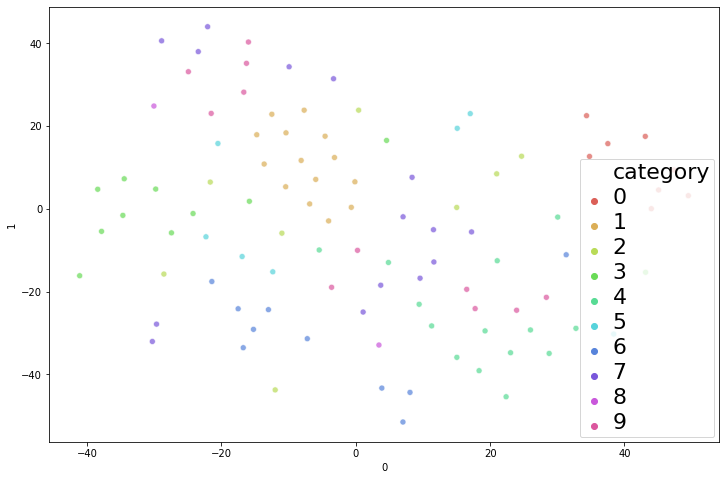

In [92]:
plot_tsne(testing_data, testing_labels)

#### transformed testing data

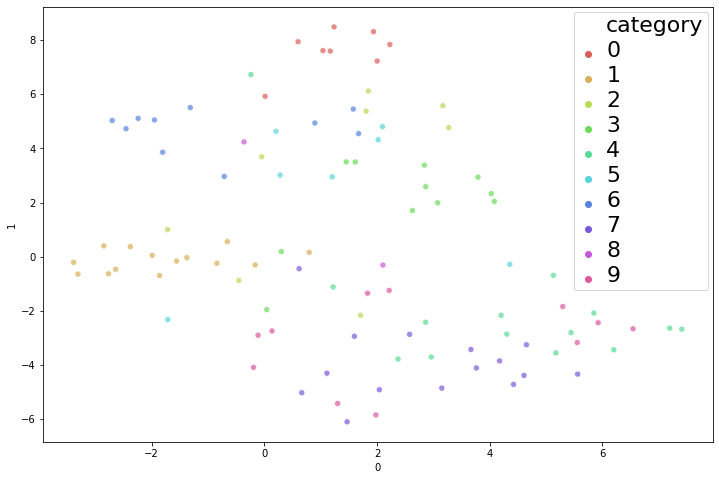

In [93]:
plot_tsne(testing_data_transformed, testing_labels)

#### Compare with LDA

In [97]:
clf = LinearDiscriminantAnalysis(n_components=5)
clf.fit(training_data, training_labels)

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=5, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [98]:
lda_transformed_testdata=clf.transform(testing_data)

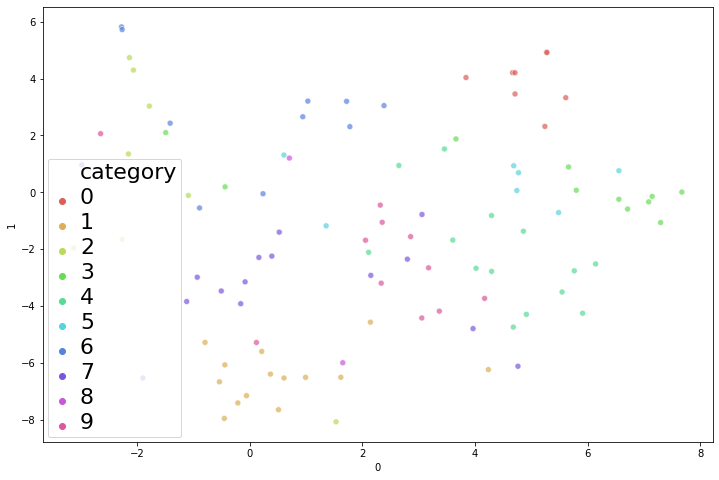

In [100]:
plot_tsne(lda_transformed_testdata, testing_labels)